## Data preparation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

# GLOBAL VARIABLES

# time horizon in years
T = 20  

# number of time steps
N = int(T * 252 * 7)  

# change remige's lenght
l_regime = int(0.5  * 252 * 7)

# time interval
dt = T / N

# GBM parameters
gbm_par = np.array(
    [[0.02, 0.2], #mu,sigma bull-regime
    [-0.02, 0.3]]) #mu,sigma bear-regime

# array of all the timesteps
timestep = np.linspace(0, T, N)

**Nota:** in realtà in questo caso non serve la funzione data_par, così come gli hyper-parametri h_1 e h_2. Tutto ciò è stato fatto solo per applicare le HMM alla stessa identica serie temporale usata per MK-means e WK-means.

In [2]:
def data_par(h_1, h_2):
    '''
    Given the hyper parameters h_1 and h_2 it returns the number of sub-sequences M and the effective number of log-returns that
    are involved in the analysis N_prime.
    
    '''
    
    # check the number of possible sub sequences M
    i = 0
    # N - 2 (-1:from price to log-return and -1:becuase the last index is lenght of the array -1)
    while ((h_1 - h_2) * i + h_1) <= (N-2):
        i = i + 1

    # IMPORTANT parameters
    M = i 
    N_prime = (h_1 - h_2) * (M-1) + h_1 + 1
    
    return N_prime, M

h_1 = 35
h_2 = 28
N_prime, M = data_par(h_1, h_2)
t = timestep[: N_prime + 1]

print(f"Price values not included in the analysis = {len(timestep) - len(t)}")

Price values not included in the analysis = 5


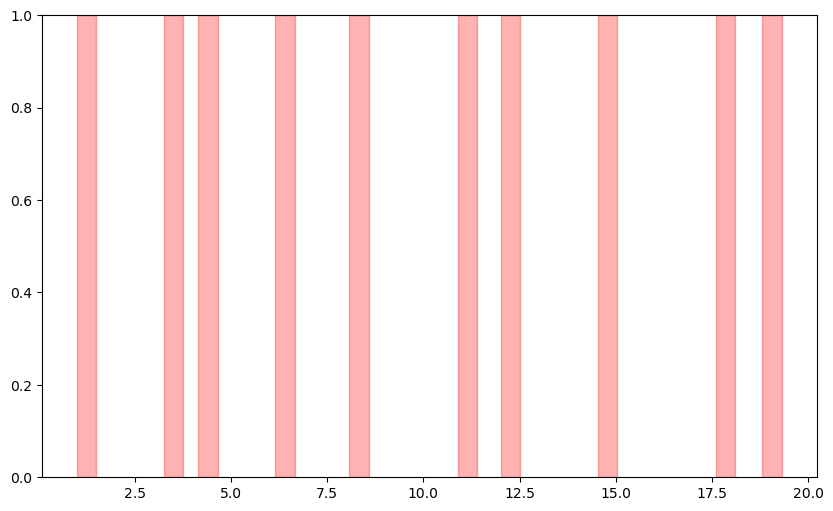

In [3]:
def generate_regimes(N_prime):
    '''
    It generates randomly 10 different time interval of the same same lenght.
    
    '''

    A = np.arange(0, N_prime+1)

    # Parametri delle sottosequenze
    num_subsequences = 10
    subseq_length = l_regime 

    # Set per memorizzare gli indici di partenza usati
    used_indices = set()

    # Funzione per generare un indice di partenza valido
    def generate_start_index(random_state=17):
        np.random.seed(random_state)
        while True:
            # Genera un indice di partenza casuale
            start_index = np.random.randint(0, len(A) - subseq_length - 1)
            # Controlla se l'indice di partenza e l'indice finale (con buffer di 1) sono validi
            if all((start_index + i) not in used_indices for i in range(subseq_length + 1)):
                for i in range(subseq_length + 1):
                    used_indices.add(start_index + i)
                return start_index

    # Generazione delle sottosequenze random non sovrapposte con almeno un elemento di distanza
    subsequences = []
    for _ in range(num_subsequences):
        start_index = generate_start_index()
        subsequences.append(A[start_index:start_index + subseq_length])

    subsequences = np.sort(np.array(subsequences), axis=0)
    
    # label for the log-returns
    B = np.zeros(N_prime)
    for sub in subsequences:
        B[sub[0]: sub[-1]] = 1    
    B = B.astype(int)

    # label for prices
    C = np.zeros(N_prime+1)
    for sub in subsequences:
        C[sub] = 1    
    C = C.astype(int)


    
    return subsequences, B, C

subsequences, theo_labels, labels_prices = generate_regimes(N_prime)

# plot of the regimes
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.axvspan(timestep[subsequences[i][0]], timestep[subsequences[i][-1]], color='red', alpha=0.3)
plt.show()

mean_path = 1.5904336169888507 
std_path = 0.8746807632129775


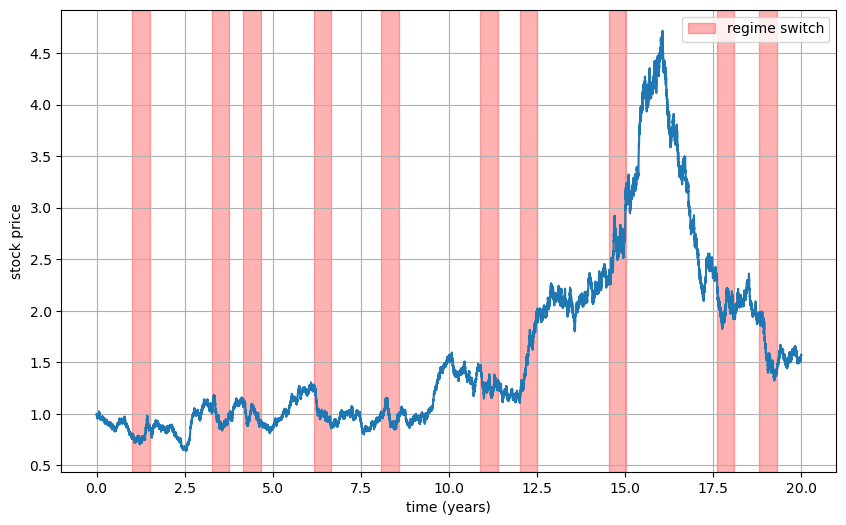

In [4]:
def gbm(S0, mu, sigma, n, dt):
    """
    Simulates a Geometric Brownian Motion (GBM).

    Parameters:
    S0 (float): Initial stock price
    mu (float): Drift coefficient
    sigma (float): Volatility coefficient
    T (float): Time horizon
    n (int): Number of time steps

    Returns:
    np.ndarray: Simulated stock prices

    """
    t = np.arange(1, n) * dt
    W = np.random.standard_normal(size=n-1) 
    W = np.cumsum(W) * np.sqrt(dt) # cumulative sum to simulate the Brownian motion
    X = (mu - 0.5 * sigma**2) * t + sigma * W
    S = np.zeros(n)
    S[0] = S0
    S[1:] = S0 * np.exp(X)
    return S

def gbm_path(N_prime, C, t):
    
    '''
    It simulates the entire path of a GBM with regimes switch.
    
    '''
    # array of prices
    s = np.zeros(N_prime + 1)
    # initial stock price
    s[0] = 1
    s_0 = s[0]
    start_index = 0
    stop_index = 1

    for k in range(1, N_prime+1):
        if k == N_prime:
            s[start_index : stop_index + 1] = gbm(s_0, gbm_par[C[k]][0], gbm_par[C[k]][1], len(t[start_index : stop_index + 1]), dt)

        elif C[k] == C[k+1]:
            stop_index = k+1

        else:
            s[start_index : stop_index + 1] = gbm(s_0, gbm_par[C[k]][0], gbm_par[C[k]][1], len(t[start_index : stop_index + 1]), dt)
            #updates
            start_index = k
            s_0 = s[k]
            stop_index = k + 1
            
    return s

# to ensure reproducibility
np.random.seed(15)

# relevant time series
prices = gbm_path(N_prime, labels_prices, t)  
log_returns = np.diff(np.log(prices))

print(f'mean_path = {np.mean(prices)} \nstd_path = {np.std(prices)}')

# plot price path
plt.figure(figsize=(10, 6))
plt.plot(t,prices)
for i in range(10):
    if i == 0:
        plt.axvspan(t[subsequences[i][0]], t[subsequences[i][-1]], color='red', alpha=0.3, label='regime switch')
        
    else:
        plt.axvspan(t[subsequences[i][0]], t[subsequences[i][-1]], color='red', alpha=0.3)
        
    
#plt.title("Geometric Brownian Motion Simulation")
plt.xlabel("time (years)")
plt.ylabel("stock price")
plt.grid()
plt.legend()
plt.show()
plt.show()

## Hidden Markov Model
Per clusterizzare i log returns con HMM ho utilizzato una libreria open source di Python consigliata da ChatGPT

In [5]:
from hmmlearn import hmm

In [6]:
%%time

# using log returns
time_series_data = log_returns.reshape(-1, 1)

# Define the HMM
model = hmm.GaussianHMM(n_components=2, covariance_type='diag', random_state=30, n_iter=100, tol=1e-2)

# Fit the HMM to the time series data
model.fit(time_series_data)

# Predict hidden states
hmm_labels = model.predict(time_series_data)
print(f'model converged? {model.monitor_.converged}')

off_regime_index = 0
on_regime_index = 1

if (hmm_labels == 0).sum() / len(hmm_labels) < 0.5:
    off_regime_index = 1
    on_regime_index = 0

model converged? True
Wall time: 1.23 s


**Issue:** 
- è un problema quando mi viene detto *Model is not converging...*? Non so come risolvere/gestire la questione...
- model.monitor_.converged mi dice che c'è convergenza però mi appare la scritta rossa *Model is not converging...*. Come si risolve la questione? Ho chiesto a ChatGPT e sotto è riportata la risposta!

The issue you're encountering stems from the convergence criteria used in hmmlearn. The model considers itself converged if the change in log likelihood between iterations is below a certain threshold (tol). However, the model might still print out a warning if the log likelihood doesn't strictly increase between iterations, even if the change is very small.

Explanation:
model.monitor_.converged: This attribute will be True if the difference in log likelihood between iterations is smaller than the tolerance (tol) set during model initialization. However, if the log likelihood decreases slightly, even by a tiny amount, the model may still consider itself "converged" based on the tol threshold but will print a warning because, ideally, the log likelihood should never decrease.

The Warning: The warning you see ("Model is not converging. Current: X is not greater than Y. Delta is Z") indicates that in that particular iteration, the log likelihood slightly decreased. This doesn't necessarily mean the model hasn't converged overall; it just failed to strictly increase the log likelihood in that specific step.

## Accuracy scores
**Nota:** rispetto al clustering con WK-means e MK-means qua i ritorni hanno un unico label e non multiplo!

In [7]:
dec = 5

# regime-off accuracy score (ROFS)
ROFS = np.sum(hmm_labels[theo_labels == 0] == off_regime_index) / len(hmm_labels[theo_labels == 0])
print(f'ROFS = {round(ROFS, dec)}')

# regime-off accuracy score (ROFS)
RONS = np.sum(hmm_labels[theo_labels == 1] == on_regime_index) / len(hmm_labels[theo_labels == 1])
print(f'RONS = {round(RONS, dec)}')

# total accuracy (TA)
TA = (np.sum(hmm_labels[theo_labels == 0] == off_regime_index) + np.sum(hmm_labels[theo_labels == 1] == on_regime_index)) / len(hmm_labels)
print(f'TA = {round(TA, dec)}')

ROFS = 0.99951
RONS = 0.98059
TA = 0.99478


# CLUSTERING VALIDATION

In [34]:
def clustering_validation(h_1 = 35, h_2 = 28, n_runs = 50):
    
    rofs = np.zeros(n_runs)
    rons = np.zeros(n_runs)
    ta = np.zeros(n_runs)
    converge_count = np.zeros(n_runs)
    iteration_times = np.zeros(n_runs)
    
    N_prime, M = data_par(h_1, h_2)
    t = timestep[: N_prime + 1]
    subs, theo_labels, price_labels = generate_regimes(N_prime)
    
    for j in range(n_runs): 
        
        # data preparation
        np.random.seed(j)
        log_returns = np.diff(np.log(gbm_path(N_prime, price_labels, t)))
        
        # clustering
        start = time.time()
        
        # using log returns
        time_series_data = log_returns.reshape(-1, 1)

        # Define the HMM
        model = hmm.GaussianHMM(n_components=2, covariance_type='diag', random_state=1, n_iter=1000, tol=1e-4)

        # Fit the HMM to the time series data
        model.fit(time_series_data)

        # Predict hidden states
        hmm_labels = model.predict(time_series_data)

        # check for convergence
        if model.monitor_.converged:
            converge_count[j] = 1

        # off/on indexes
        off_regime_index = 0
        on_regime_index = 1

        if (hmm_labels == 0).sum() / len(hmm_labels) < 0.5:
            off_regime_index = 1
            on_regime_index = 0

        # regime-off accuracy score (ROFS)
        rofs[j] = np.sum(hmm_labels[theo_labels == 0] == off_regime_index) / len(hmm_labels[theo_labels == 0])

        # regime-off accuracy score (ROFS)
        rons[j] = np.sum(hmm_labels[theo_labels == 1] == on_regime_index) / len(hmm_labels[theo_labels == 1])

        # total accuracy (TA)
        ta[j] = (np.sum(hmm_labels[theo_labels == 0] == off_regime_index) + np.sum(hmm_labels[theo_labels == 1] == on_regime_index)) / len(hmm_labels)

        iteration_times[j] = time.time() - start

    return rofs, rons, ta, converge_count, iteration_times

In [35]:
%%time
n_runs = 50
dec = 4
rofs, rons, ta, converge_count, iteration_times = clustering_validation(h_1 = 35, h_2 = 28, n_runs = n_runs)
print(f"ROFS = {round(np.mean(rofs), dec)} -+ {round(np.std(rofs), dec)}")
print(f"RONS = {round(np.mean(rons), dec)} -+ {round(np.std(rons), dec)}")
print(f"TA = {round(np.mean(ta), dec)} -+ {round(np.std(ta), dec)}")
print(f"RUN TIME = {round(np.mean(iteration_times), dec)} -+ {round(np.std(iteration_times), dec)}")

print(f'\nCONVERGENCE RATE = {np.sum(convergence_count)/n_runs}')
if (convergence_count == 1).all():
    print('every iteration reaches convergence!')

Model is not converging.  Current: 135039.22896784343 is not greater than 135039.23579747538. Delta is -0.0068296319514047354
Model is not converging.  Current: 135013.2871805624 is not greater than 135013.28828680018. Delta is -0.0011062377889174968
Model is not converging.  Current: 135054.95527533774 is not greater than 135054.97145670382. Delta is -0.016181366081582382
Model is not converging.  Current: 134832.4652313334 is not greater than 134832.4659173753. Delta is -0.0006860418943688273
Model is not converging.  Current: 134798.5229736335 is not greater than 134798.54337363993. Delta is -0.020400006440468132
Model is not converging.  Current: 134924.14285313222 is not greater than 134924.16688882935. Delta is -0.024035697133513168
Model is not converging.  Current: 134929.46301515214 is not greater than 134929.48673437594. Delta is -0.023719223798252642
Model is not converging.  Current: 135080.65564492793 is not greater than 135080.6675452959. Delta is -0.011900367971975356
Mo

ROFS = 0.9981 -+ 0.001
RONS = 0.9651 -+ 0.137
TA = 0.9898 -+ 0.034
RUN TIME = 2.8113 -+ 3.6574

CONVERGENCE RATE = 1.0
every iteration reaches convergence!
Wall time: 2min 21s


In [36]:
# print the results as txt file

df = pd.DataFrame({
    'ROFS': rofs,
    'RONS': rons,
    'TA': ta,
    'CONVERGENCE': convergence_count,
    'RUNTIME': iteration_times
})

# check the valuse of the parameters below! 
# REMINDER:
# hmm, h=h_1,h_2, path = gbm, seed of the clustering = 30, n_trials=50, max_ite = 1000, tol=1e-4
# name of the file = 'numerical_results/hmm_h_35_28_gbm_30_n_50_ite_1000_tol_4.txt'

df.to_csv('numerical_results/hmm_h_35_28_gbm_free_n_50_ite_1000_tol_4.txt', index=False)

In [ ]:
# read the results
df = pd.read_csv('numerical_results/hmm_h_35_28_gbm_30_n_50_ite_1000_tol_4.txt')
n_runs = 50

rofs = df['ROFS'].values
rons = df['RONS'].values
ta = df['TA'].values
convergence_count = df['CONVERGENCE'].values
iteration_times = df['RUNTIME'].values

print(f'ROFS = {np.mean(rofs)} +- {np.std(rofs)}')

print(f'\nRONS = {np.mean(rons)} +- {np.std(rons)}')

print(f'\nTA = {np.mean(ta)} +- {np.std(ta)}')

print(f'\nRUN TIME = {np.mean(iteration_times)} +- {np.std(iteration_times)} seconds')

print(f'\nCONVERGENCE RATE = {np.sum(convergence_count)/n_runs}')
if (convergence_count == 1).all():
    print('every iteration reaches convergence!')

# dependences by the seed

In [53]:
# WARNING: run again if you change something in Data preparation (as the price path), n_iter and tol !!!

def hmm_function(random_seed):
    
    # using log returns
    time_series_data = log_returns.reshape(-1, 1)

    # Define the HMM
    model = hmm.GaussianHMM(n_components=2, covariance_type='diag', random_state=random_seed, n_iter=1000, tol=1e-2)

    # Fit the HMM to the time series data
    model.fit(time_series_data)

    # Predict hidden states
    hmm_labels = model.predict(time_series_data)
    
    # check for convergence
    converged_count = 0
    if model.monitor_.converged:
        converged_count = 1

    # off/on indexes
    off_regime_index = 0
    on_regime_index = 1

    if (hmm_labels == 0).sum() / len(hmm_labels) < 0.5:
        off_regime_index = 1
        on_regime_index = 0
         
    # regime-off accuracy score (ROFS)
    ROFS = np.sum(hmm_labels[theo_labels == 0] == off_regime_index) / len(hmm_labels[theo_labels == 0])

    # regime-off accuracy score (ROFS)
    RONS = np.sum(hmm_labels[theo_labels == 1] == on_regime_index) / len(hmm_labels[theo_labels == 1])

    # total accuracy (TA)
    TA = (np.sum(hmm_labels[theo_labels == 0] == off_regime_index) + np.sum(hmm_labels[theo_labels == 1] == on_regime_index)) / len(hmm_labels)
    
    return ROFS, RONS, TA, converged_count

In [1]:
def convert_seconds(seconds):
    minutes = int(seconds // 60)
    remaining_seconds = seconds % 60
    return f"{minutes} min {int(remaining_seconds)} seconds"

In [54]:
n_trials = 50
rofs = np.zeros(n_trials)
rons = np.zeros(n_trials)
ta = np.zeros(n_trials)

convergence_count = np.zeros(n_trials)
iteration_times = np.zeros(n_trials)

start_time_tot = time.time()
for i in range(n_trials):
    # start
    start_time = time.time()
    # real computation
    rofs[i], rons[i], ta[i], convergence_count[i] = hmm_function(i+1)
    # end
    end_time = time.time()
    # save data
    iteration_times[i] = end_time - start_time
end_time_tot = time.time()

input_seconds = float(end_time_tot - start_time_tot)
print(f'time to complete all the iterations = {convert_seconds(input_seconds)}')

Model is not converging.  Current: 134624.0479980325 is not greater than 134624.04941798377. Delta is -0.001419951266143471
Model is not converging.  Current: 133496.80662931595 is not greater than 133496.8117705132. Delta is -0.0051411972381174564
Model is not converging.  Current: 134624.04794541618 is not greater than 134624.0493277633. Delta is -0.0013823471090290695
Model is not converging.  Current: 134624.04798847288 is not greater than 134624.0494069985. Delta is -0.001418525615008548
Model is not converging.  Current: 133496.85351017475 is not greater than 133496.86241773097. Delta is -0.008907556213671342
Model is not converging.  Current: 133496.75340723188 is not greater than 133496.75914809408. Delta is -0.005740862194215879
Model is not converging.  Current: 134624.04812469307 is not greater than 134624.0494695008. Delta is -0.0013448077370412648
Model is not converging.  Current: 134624.04785516075 is not greater than 134624.04918594027. Delta is -0.0013307795161381364
M

time to complete all the iterations = 2 min 0 seconds


In [57]:
# print the results as txt file

df = pd.DataFrame({
    'ROFS': rofs,
    'RONS': rons,
    'TA': ta,
    'CONVERGENCE': convergence_count,
    'RUNTIME': iteration_times
})

# check the valuse of the parameters below! 
# REMINDER:
# hmm, accuracy scores, path = gbm, seed of the fixed path = 15, n_trials=50, max_ite = 1000, tol = 1e-2
# name of the file = 'numerical_results/hmm_accuracy_scores_gbm_15_n_50_ite_1000_tol_2.txt'

# df.to_csv('numerical_results_stability/hmm_accuracy_scores_gbm_15_n_50_ite_1000_tol_2.txt', index=False)

In [17]:
# read the results
df = pd.read_csv('numerical_results_stability/hmm_accuracy_scores_gbm_15_n_50_ite_1000_tol_4.txt')
n_trials = 50

rofs = df['ROFS'].values
rons = df['RONS'].values
ta = df['TA'].values
convergence_count = df['CONVERGENCE'].values
iteration_times = df['RUNTIME'].values

print(f'ROFS = {np.mean(rofs)} +- {np.std(rofs)}')
# print(f'ROFS_max = {np.max(rofs)} \nROFS_min = {np.min(rofs)}')

print(f'\nRONS = {np.mean(rons)} +- {np.std(rons)}')
# print(f'RONS_max = {np.max(rons)} \nRONS_min = {np.min(rons)}')

print(f'\nTA = {np.mean(ta)} +- {np.std(ta)}')
# print(f'TA_max = {np.max(ta)} \nTA_min = {np.min(ta)}')

print(f'\nRUN TIME = {np.mean(iteration_times)} +- {np.std(iteration_times)} seconds')

print(f'\nCONVERGENCE RATE = {np.sum(convergence_count)/n_trials}')
if (convergence_count == 1).all():
    print('every iteration reaches convergence!')

ROFS = 0.8992215840386941 +- 0.19929058712869865

RONS = 0.8852735527809308 +- 0.19336470851871496

TA = 0.8957379372909224 +- 0.19780802674797132

RUN TIME = 2.687381820678711 +- 3.728056039003913 seconds

CONVERGENCE RATE = 1.0
every iteration reaches convergence!


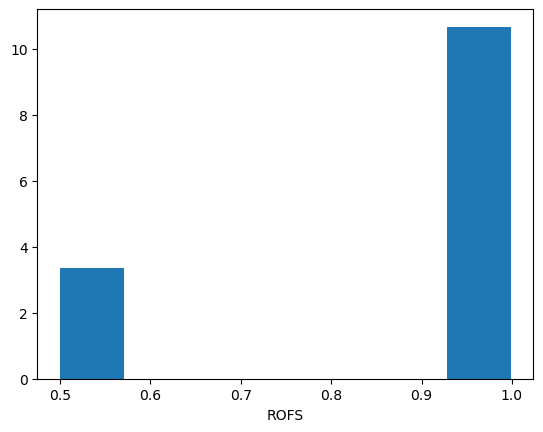

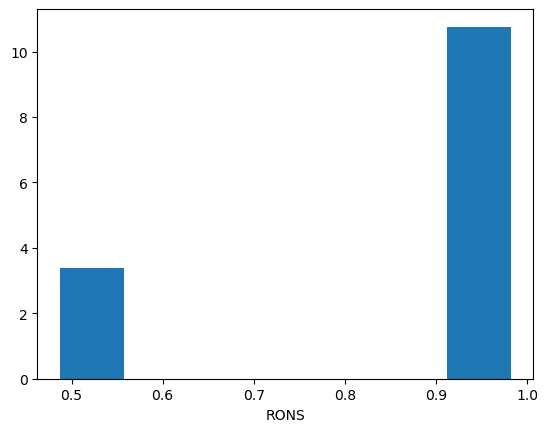

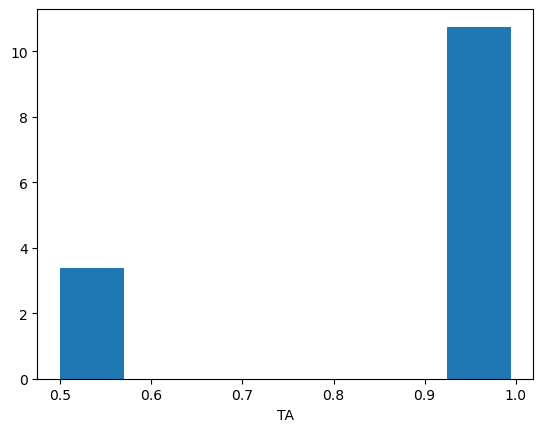

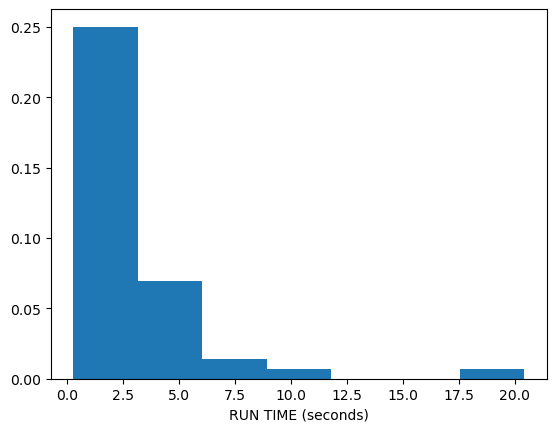

In [56]:
nn_bins = int(np.sqrt(n_trials))
# nn_bins = n_trials

plt.figure(1)
plt.hist(rofs, bins=nn_bins, density=True)
plt.xlabel('ROFS')

plt.figure(2)
plt.hist(rons, bins=nn_bins, density=True)
plt.xlabel('RONS')

plt.figure(3)
plt.hist(ta, bins=nn_bins, density=True)
plt.xlabel('TA')

plt.figure(4)
plt.hist(iteration_times, bins=nn_bins, density=True)
plt.xlabel('RUN TIME (seconds)')

# plt.figure(5)
# plt.hist(convergence_count, bins=nn_bins, density=True)
# plt.xlabel('RUN TIME (seconds)')

plt.show()